# Clasificacion Wine Data
Este dataset se llama "Wine Recognition Data" y trata sobre un análisis químico realizado en vinos de la misma región en Italia, pero de tres tipos diferentes de uvas o cultivares. La idea es que se analizaron 13 componentes químicos presentes en estos vinos, como el alcohol, el ácido málico, y otros compuestos.

El dataset tiene 178 muestras en total, distribuidas entre tres clases (o tipos de vino). Cada muestra tiene 13 atributos, todos ellos son continuos, lo que significa que son números que pueden tomar cualquier valor dentro de un rango.

Se busca la creacion de un modelo de clasificacion con el fin de clasificar las 3 tipos de vino

#Se realiza la importacion de las Librerias a utilziar en la creacion del modelo

In [0]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.linear_model import RidgeClassifier





In [0]:
mlflow.start_run()

---------------------------------------------------------------------------
Exception                                 Traceback (most recent call last)
File <command-2682246642522353>, line 1
----> 1 mlflow.start_run()

File /databricks/python/lib/python3.10/site-packages/mlflow/tracking/fluent.py:287, in start_run(run_id, experiment_id, run_name, nested, tags, description)
    285 experiment_id = str(experiment_id) if isinstance(experiment_id, int) else experiment_id
    286 if len(_active_run_stack) > 0 and not nested:
--> 287     raise Exception(
    288         (
    289             "Run with UUID {} is already active. To start a new run, first end the "
    290             + "current run with mlflow.end_run(). To start a nested "
    291             + "run, call start_run with nested=True"
    292         ).format(_active_run_stack[0].info.run_id)
    293     )
    294 client = MlflowClient()
    295 if run_id:

Exception: Run with UUID 7ff0d6d82bec4a0e8543e425b24cbd70 is already 

In [0]:
mlflow.log_param("version_mlflow", mlflow.__version__)
mlflow.log_param("version_pandas", pd.__version__)
mlflow.log_param("version_numpy", np.__version__)
#mlflow.log_param("version_matplotlib", matplotlib.__version__)
mlflow.log_param("version_seaborn", sns.__version__)
#mlflow.log_param("version_sklearn", sklearn.__version__)
#mlflow.log_param("version_imblearn", imblearn_version)

'0.11.2'

###Realizamos la lectura del dataset y a la vez la asignacion de los nombres de cada variable predictora

In [0]:
campos = ['Target', 'Alcohol', 'Acido_malico','Ceniza', 'Alcalinidad_cenizas', 'Magnesio', 'Fenoles_totales','Flavonoides','Fenoles_no_flavonoides', 'Proantocianinas', 'Intensidad_color', 'Matiz', 'OD280/OD315_Vinos_diluidos', 'Prolina']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', names=campos, index_col=False)
# Eliminar el índice
df = df.reset_index(drop=True)

In [0]:
# Registro de estadísticas y características de los datos
mlflow.log_param("num_columns", df.shape[1])
mlflow.log_param("num_rows", df.shape[0])
mlflow.log_param("missing_values", df.isnull().sum().sum())
mlflow.log_param("duplicated_rows", df.duplicated().sum())

0

In [0]:
df.head()

,Target,Alcohol,Acido_malico,Ceniza,Alcalinidad_cenizas,Magnesio,Fenoles_totales,Flavonoides,Fenoles_no_flavonoides,Proantocianinas,Intensidad_color,Matiz,OD280/OD315_Vinos_diluidos,Prolina
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# 1. Conoceremos las estadisticas de la data y realizaremos  un analisis exploratorio de los datos para asi tener un mejor contexto del preprocesameinto que se debe realizar y como estan distribuidos los datos.

 Generamos una estadística descriptiva en la cual podemos ver el resumen de la distribución de cada uno de los atributos que componen el dataset.
 Podemos observar que existen características con rangos y desviaciones estándar muy diferentes, como la prolina, que tiene un rango mucho mayor y una desviación estándar demasiado alta 
 en comparación con la característica de la ceniza, que tiene un rango y desviación estándar más bajos.
 Debido a esta cualidad de los datos, se realizará un procesamiento para la estandarización, ya que algunas características tienen escalas diferentes.
 Con esta estandarización, garantizaremos que todas las características tengan una media de cero y una desviación estándar de 1, permitiendo así la convergencia de los algoritmos y el mejor rendimiento de los modelos.

In [0]:
describe = df.describe()

In [0]:
describe_path = "describe_summary.csv"
describe.to_csv(describe_path)
mlflow.log_artifact(describe_path)

Podemos observar la información del dataframe, el cual tiene características de tipo entero y flotante.
Se puede notar que no tenemos valores nulos o faltantes en el dataframe.
El dataframe contiene datos estructurados de variables continuas.
Se observa que existen 13 variables predictoras y una variable a predecir.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Target                      178 non-null    int64  
 1   Alcohol                     178 non-null    float64
 2   Acido_malico                178 non-null    float64
 3   Ceniza                      178 non-null    float64
 4   Alcalinidad_cenizas         178 non-null    float64
 5   Magnesio                    178 non-null    int64  
 6   Fenoles_totales             178 non-null    float64
 7   Flavonoides                 178 non-null    float64
 8   Fenoles_no_flavonoides      178 non-null    float64
 9   Proantocianinas             178 non-null    float64
 10  Intensidad_color            178 non-null    float64
 11  Matiz                       178 non-null    float64
 12  OD280/OD315_Vinos_diluidos  178 non-null    float64
 13  Prolina                     178 non

In [0]:
#Registramos la info del dataset original
info_path = "df_info.txt"
with open(info_path, "w") as f:
    
    df.info(buf=f)

    
mlflow.log_artifact(info_path)

Validamos el tamaño del dataframe para mantener la congruencia en la etapoa del procesamiento de los dtos

In [0]:

df.shape

(178, 14)

validamos el tipo de datos que contienen las variables observando asi que estan correctamente estructuradas en variales continuas

In [0]:
df.dtypes

Target                          int64
Alcohol                       float64
Acido_malico                  float64
Ceniza                        float64
Alcalinidad_cenizas           float64
Magnesio                        int64
Fenoles_totales               float64
Flavonoides                   float64
Fenoles_no_flavonoides        float64
Proantocianinas               float64
Intensidad_color              float64
Matiz                         float64
OD280/OD315_Vinos_diluidos    float64
Prolina                         int64
dtype: object

Se realiza un analiziz exploratorio de los datos a nivel de graficos, donde se graficara un histograma, grafico de densidad y un boxplot esto con el fin de obtener  perspectiva única y complementaria sobre la distribución y características de los datos, corroborando asi con la informacion observada en el proceso de df.describe() donde se encontraba las estadisticas del dataset.

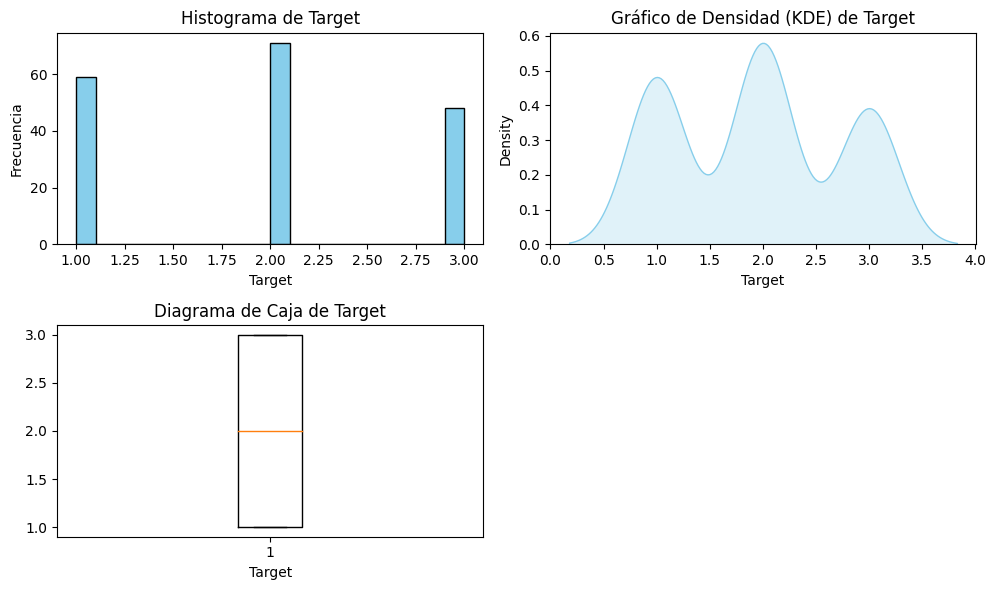

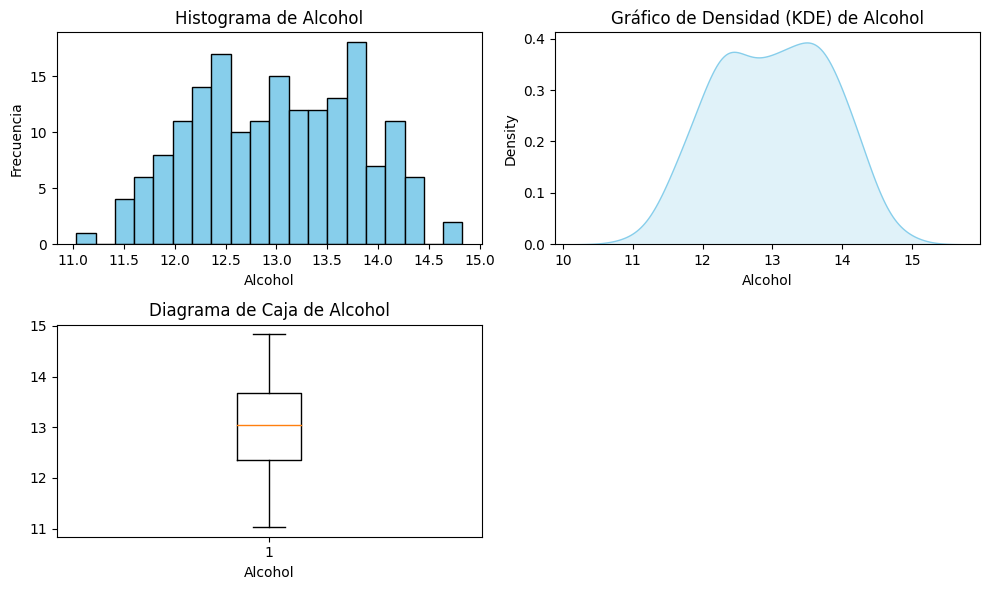

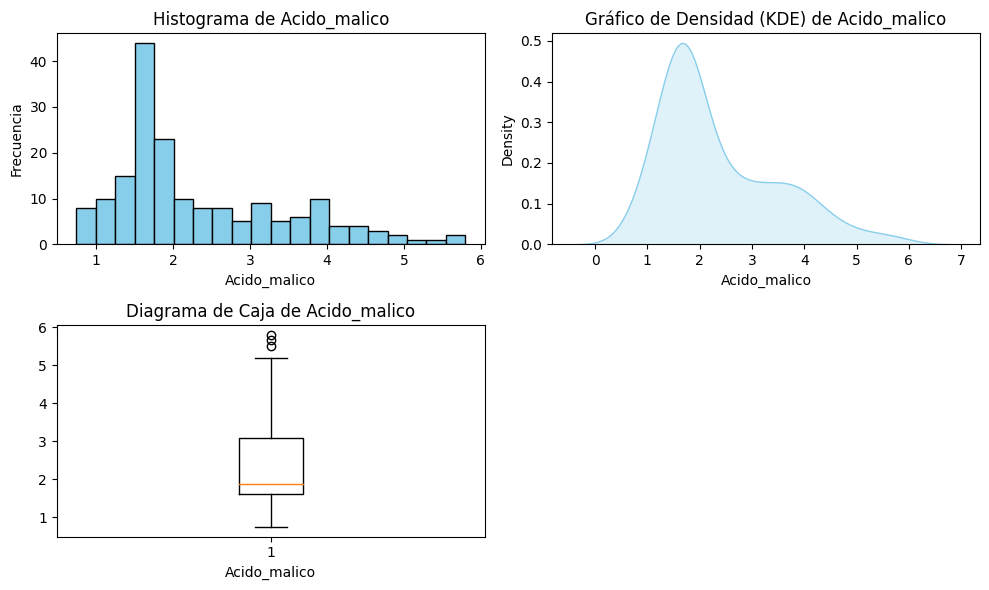

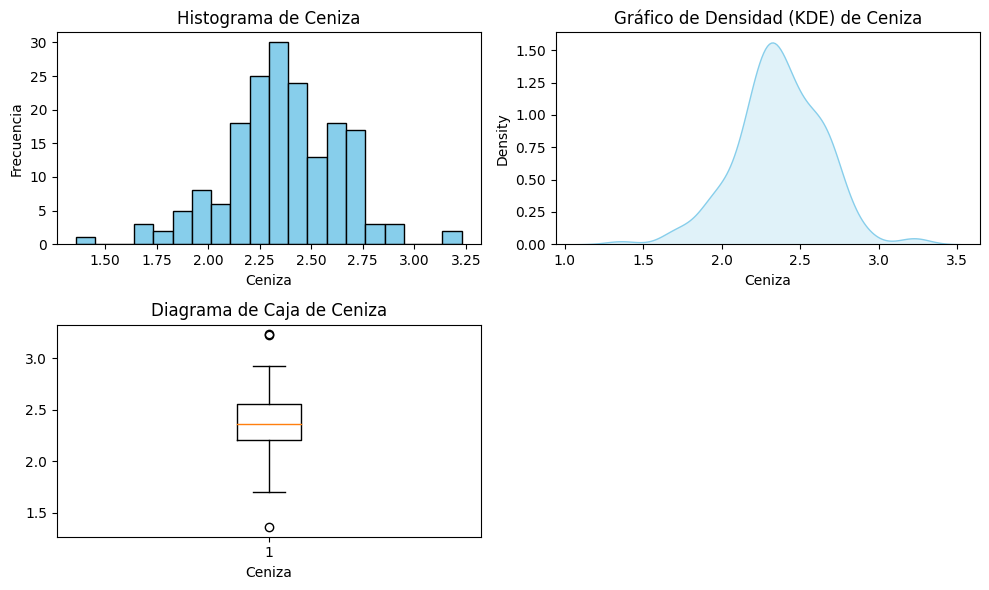

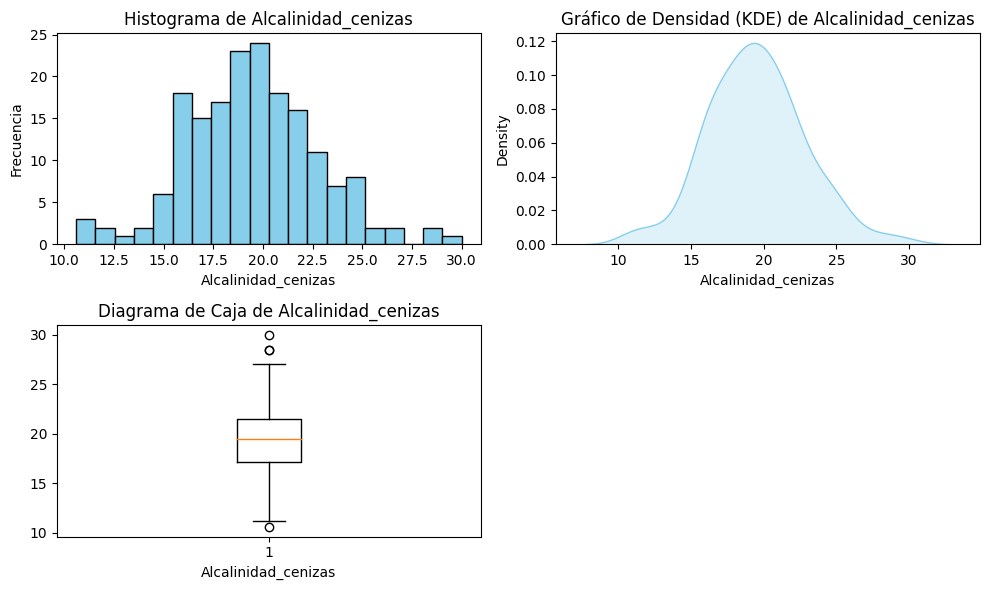

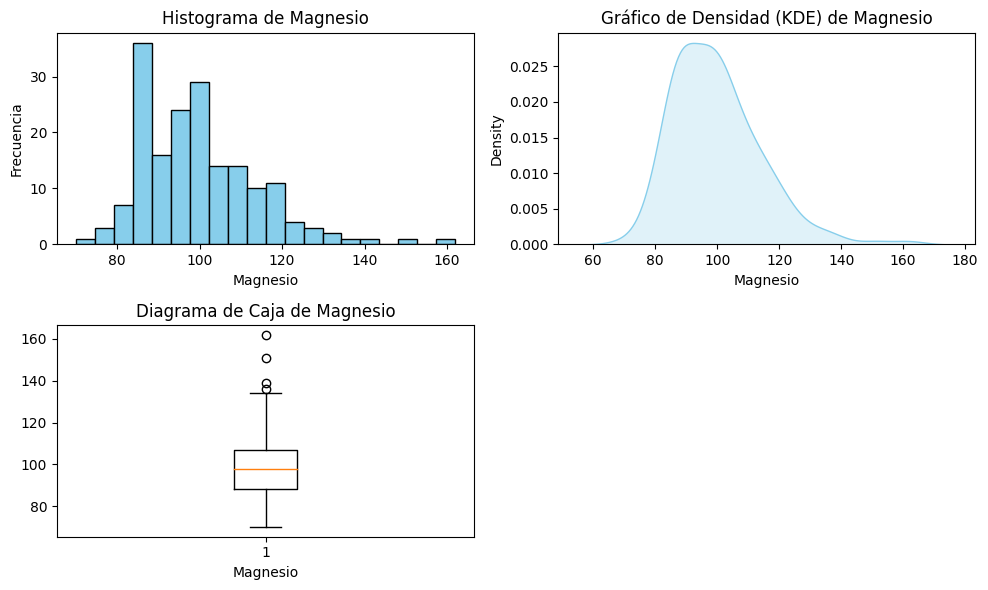

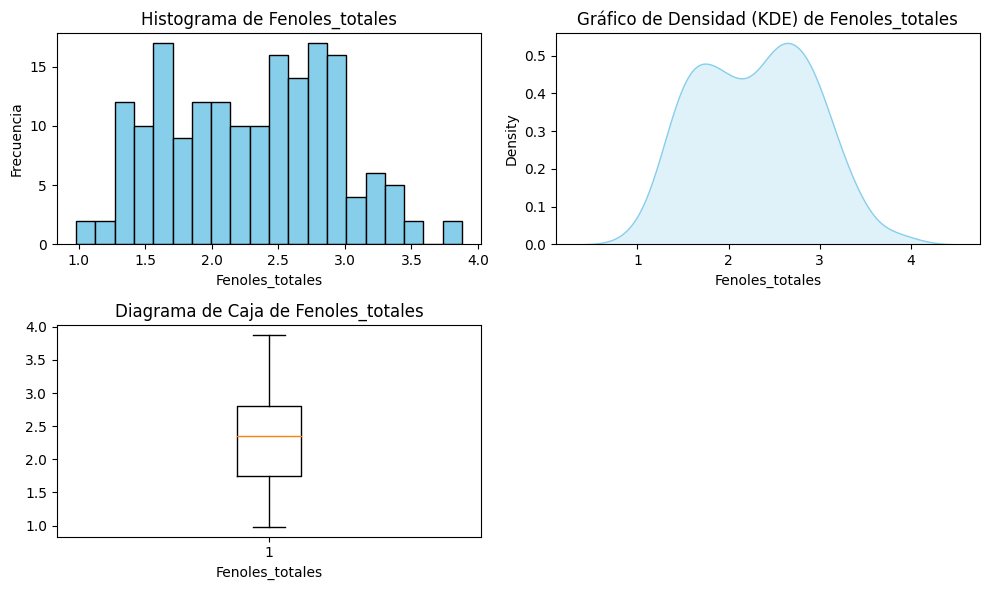

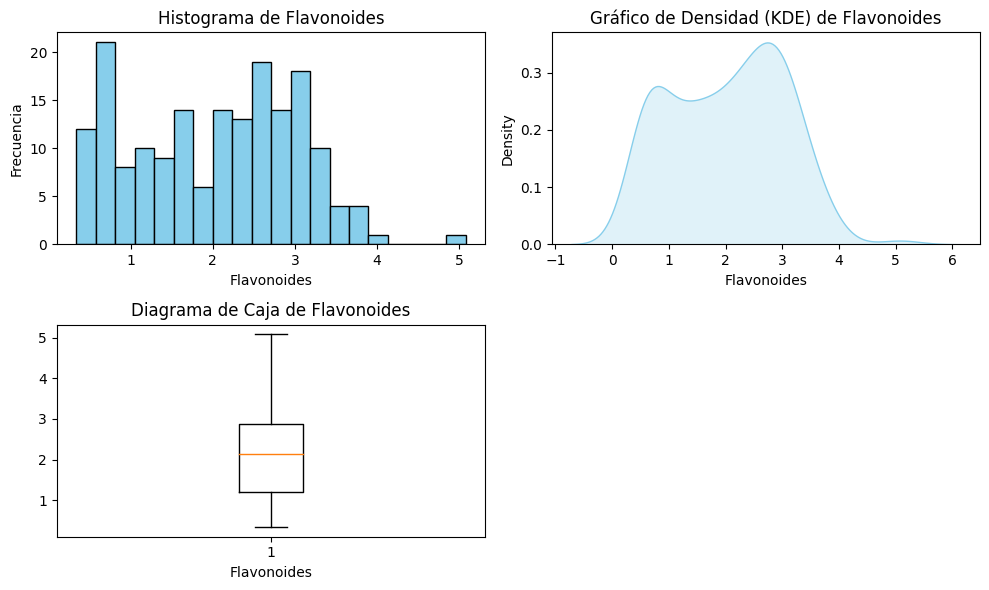

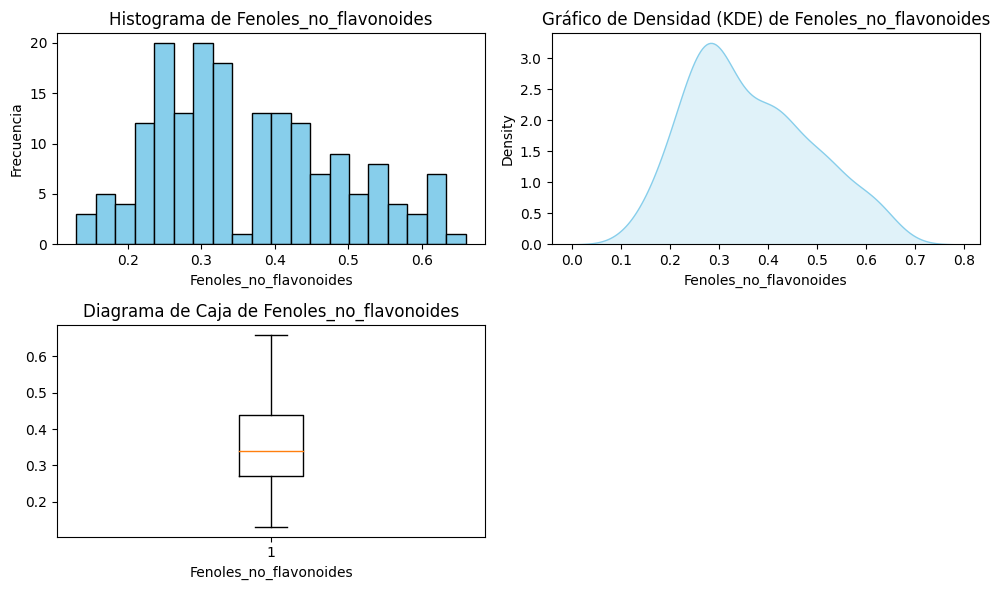

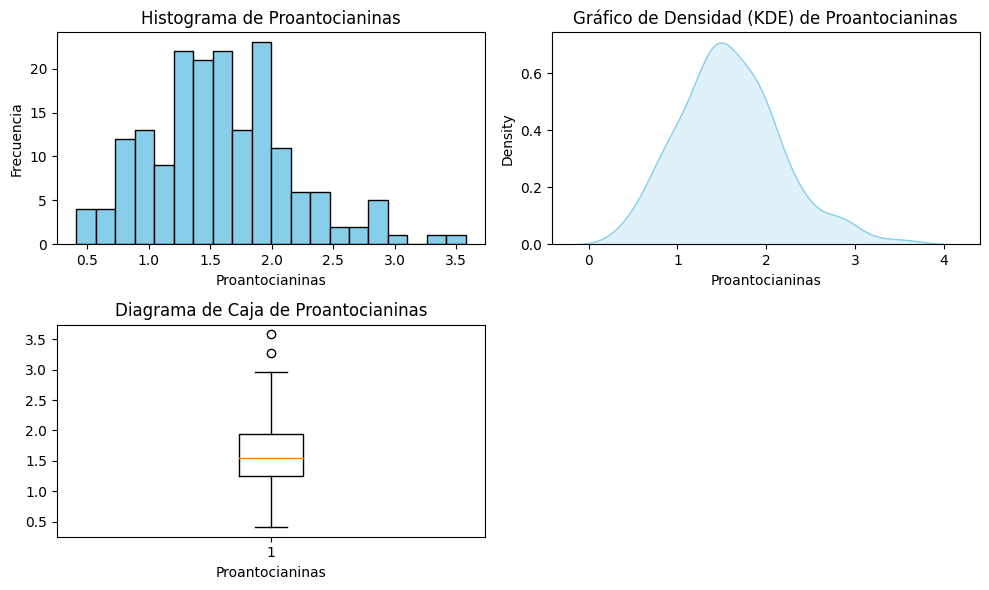

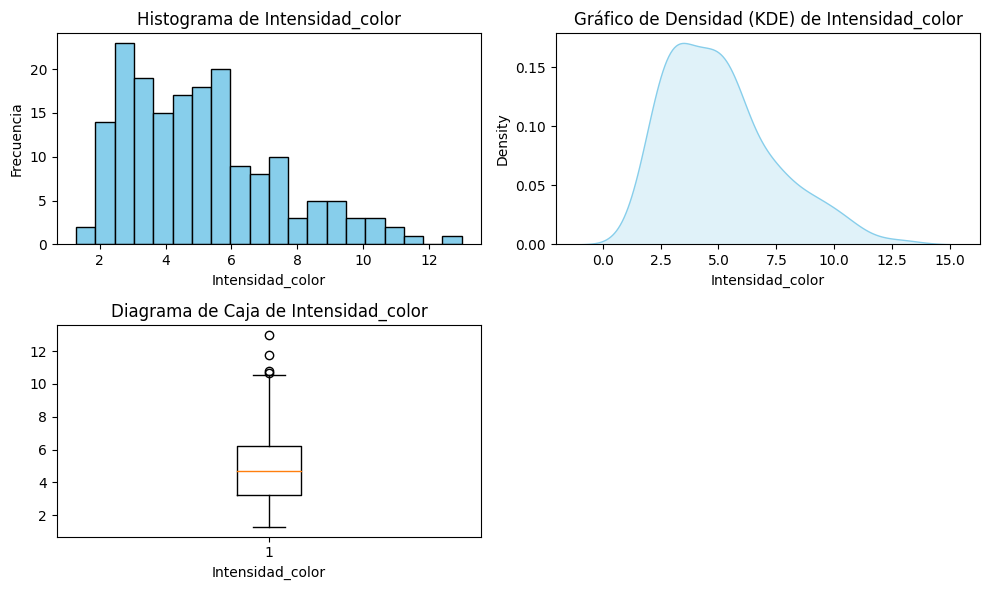

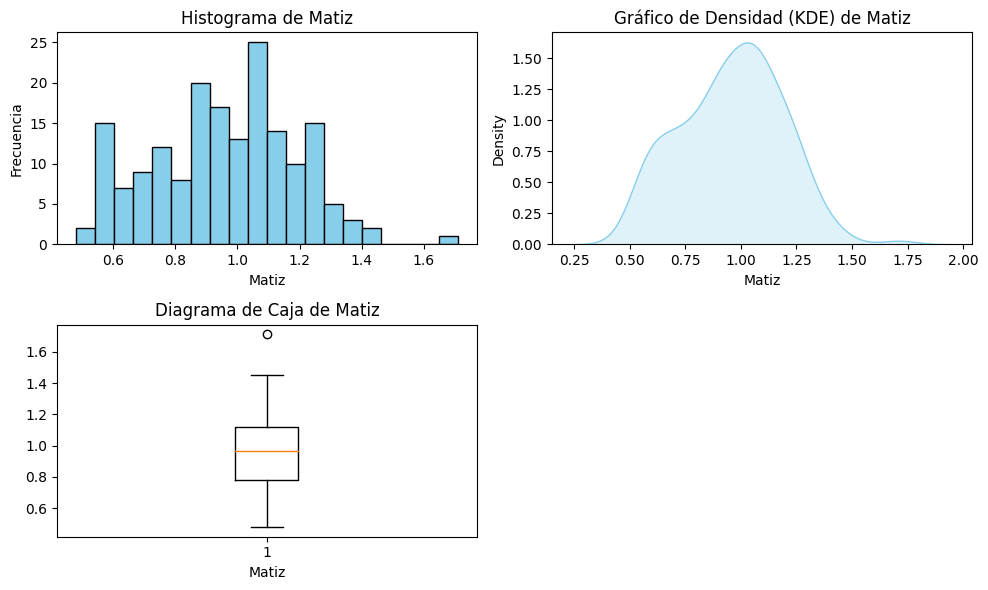

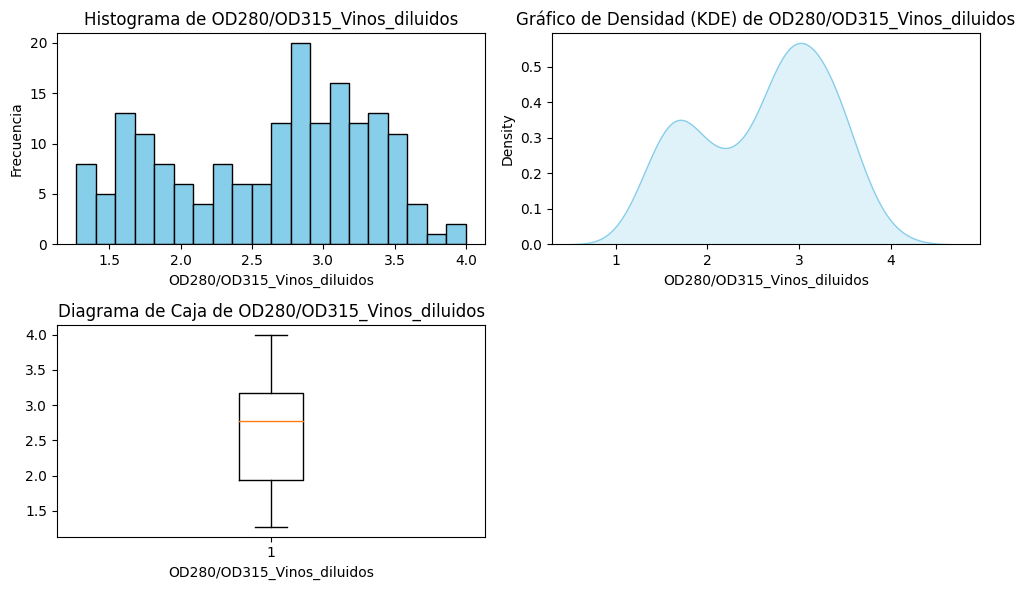

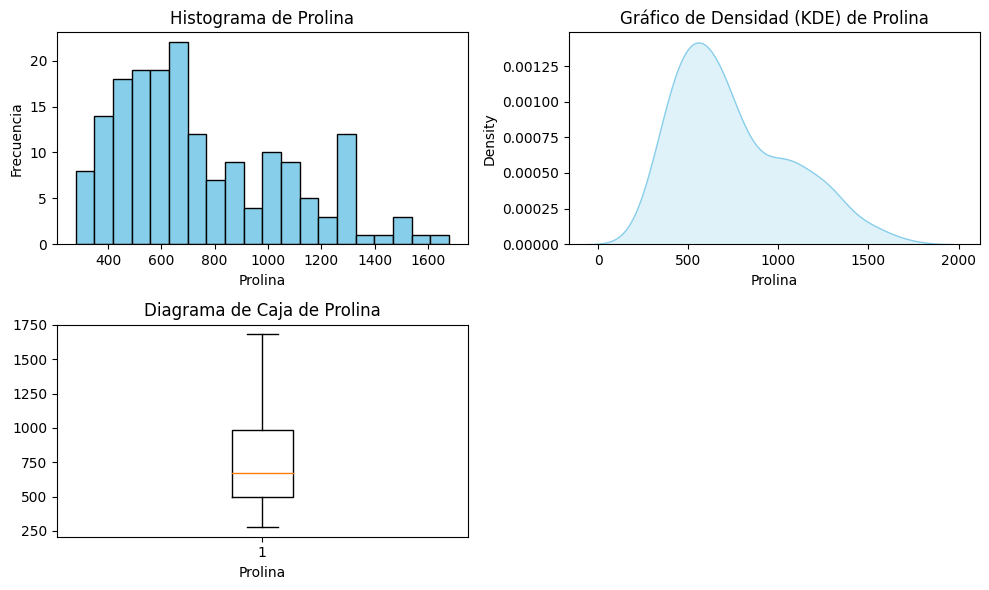

In [0]:
#Graficos
for column in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 2, 1)
    plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.title('Histograma de {}'.format(column))

    plt.subplot(2, 2, 2)
    sns.kdeplot(df[column], shade=True, color='skyblue')
    plt.xlabel(column)
    plt.title('Gráfico de Densidad (KDE) de {}'.format(column))

    plt.subplot(2, 2, 3)
    plt.boxplot(df[column])
    plt.xlabel(column)
    plt.title('Diagrama de Caja de {}'.format(column))

    plt.tight_layout()
    plt.show()

se realiza una validacion de los datos nulos en el dataframe, esto con el fin de observar si hay datos faltantes o si por el contrario tenemos un valor nulo el cual pueda afectar la creacion del modelo de clasificacion

In [0]:
df.isnull().sum()

Target                        0
Alcohol                       0
Acido_malico                  0
Ceniza                        0
Alcalinidad_cenizas           0
Magnesio                      0
Fenoles_totales               0
Flavonoides                   0
Fenoles_no_flavonoides        0
Proantocianinas               0
Intensidad_color              0
Matiz                         0
OD280/OD315_Vinos_diluidos    0
Prolina                       0
dtype: int64

In [0]:
#registramos los registros Nulos o faltantes del dataframe
Val_Faltantes = df.isnull().sum()
for column, count in Val_Faltantes.items():
    mlflow.log_metric(f"Val_Faltantes{column}", count)

se realiza un conteno y validacion de registros duplicados en el dataframe, con lo cual podemos observar que no tenemos ningun registro duplicado

In [0]:
registros_duplicados = df[df.duplicated()]
conteo_duplicados = len(registros_duplicados)
conteo_duplicados

0

In [0]:
mlflow.log_metric("conteo_Registro_duplicados", conteo_duplicados)

In [0]:
# Podemos ver que No existen registros  duplciaods
registros_duplicados = df[df.duplicated()]
registros_duplicados

,Target,Alcohol,Acido_malico,Ceniza,Alcalinidad_cenizas,Magnesio,Fenoles_totales,Flavonoides,Fenoles_no_flavonoides,Proantocianinas,Intensidad_color,Matiz,OD280/OD315_Vinos_diluidos,Prolina


De igual manera validamos si existen valores extraños en el dataframe

In [0]:
'?' in df

False

validamos que no existan valores no numericos en el dataframe

In [0]:
non_numeric_cells = df.isna().sum()
non_numeric_cells

Target                        0
Alcohol                       0
Acido_malico                  0
Ceniza                        0
Alcalinidad_cenizas           0
Magnesio                      0
Fenoles_totales               0
Flavonoides                   0
Fenoles_no_flavonoides        0
Proantocianinas               0
Intensidad_color              0
Matiz                         0
OD280/OD315_Vinos_diluidos    0
Prolina                       0
dtype: int64

Se realiza un proceso de validacion de la distribucion de los datos con el fin de verificar si existe una data desbalanceada En este caso podemos ver que por el tamaño del Dataset existe un desbalanceo en algunas caracteristcias del dataset

In [0]:
df.Target.value_counts()

2    71
1    59
3    48
Name: Target, dtype: int64

In [0]:
# 
dif21 = round(((71-59)/71)*100,2)
dif23 = round(((71-48)/71)*100,2)
dif13 = round(((59-48)/59)*100,2)

print(f"Diferencia de desbalanceo entre clase 2 y clase 1 {dif21}%")
print(f"Diferencia de desbalanceo entre clase 2 y clase 3 {dif23}%")
print(f"Diferencia de desbalanceo entre clase 1 y clase 3 {dif13}%")

Diferencia de desbalanceo entre clase 2 y clase 1 16.9%
Diferencia de desbalanceo entre clase 2 y clase 3 32.39%
Diferencia de desbalanceo entre clase 1 y clase 3 18.64%


In [0]:
#Registramos las diferencia entre las clases 
mlflow.log_metric("diferencia_desbalanceo_clase_2_vs_clase_1", dif21)
mlflow.log_metric("diferencia_desbalanceo_clase_2_vs_clase_3", dif23)
mlflow.log_metric("diferencia_desbalanceo_clase_1_vs_clase_3", dif13)

Se plantea un rango de desbalanceo en el dataset de la siguiente manera: Desbalanceo Leve (Entre en 20 y 30 %) el cual se concidera aceptable para utilziar en el modelo Desbalanceo Moderado (Entre en 30 y 50 %) el cual se concidera que puede tener un impacti en el rendimiento del modelo Desbalanceo Severo (Mayor a 50 %) el cual se concidera que puede tener un impacto en el rendimiento del modelo

Dado a este plantemaiento y viendo el porcentaje de diferencia entre las clases 1,2 y se considera que existe un desbalanceo moderado entre la clase 2 y3, pero ya que supera en 2.39 punto el umbral propuesto se lantea aplicar la tecnica de Balanceo de Data mediante la tecnica de SMOTE Synthetic Minority Over-sampling Technique la cual es uan tecnica de soremuestreo utilziada para la trata de desbalanceo de datos, el cual genera nuevas muestras sinteticas para aquellas clases minoritarias ayudando a tener un equilibrio en el numero de ejemplos de las diferentes clases. En este tecnica se utilizan los K vecinos mas cercanos para asi poder generar las muestras sinteticas, este parametro se configura para generar data balanceadd

El proceso de balanceo se realizara en un proceso posterior.

2    71
1    59
3    48
Name: Target, dtype: int64

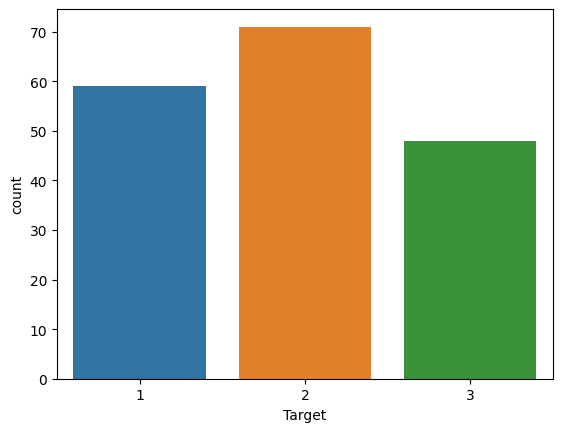

In [0]:
sns.countplot(data= df, x = "Target")
df.Target.value_counts()

Tras realizar el análisis exploratorio de los datos, podemos concluir que estos se encuentran en un formato adecuado para la construcción del modelo y que cumplen con las características óptimas en cuanto a las variables predictoras. Sin embargo, es necesario llevar a cabo un proceso de estandarización, ya que los datos no están en una escala unifor esto se observa en los graficos y estadisticas del dataframe planteados anteriormenteme, lo que podría generar ruido al construir el modelo. Además, se observa un desbalanceo moderado en los datos de las clases 2 y 3, por lo cual se procederá a balancear los dat este proceso de standarizacion y balanceo de datos se realziara en pasos posterioresos.

In [0]:
df.head()

,Target,Alcohol,Acido_malico,Ceniza,Alcalinidad_cenizas,Magnesio,Fenoles_totales,Flavonoides,Fenoles_no_flavonoides,Proantocianinas,Intensidad_color,Matiz,OD280/OD315_Vinos_diluidos,Prolina
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Se realiza un proceso de shuffle en el dataset esto el fin de evitar sesgos al momento de realziar el entrenamiento de los datos, ya que el dataset se encuentra agrupado y organizado teniendo en cuenta los tipos de clases de la variable a predecir

In [0]:


# Ralizo un shuffle para evitar cualquier sesgo
from sklearn.utils import shuffle
dfT = shuffle(df)
dfT.reset_index(drop=True, inplace=True)
dfT.head()

,Target,Alcohol,Acido_malico,Ceniza,Alcalinidad_cenizas,Magnesio,Fenoles_totales,Flavonoides,Fenoles_no_flavonoides,Proantocianinas,Intensidad_color,Matiz,OD280/OD315_Vinos_diluidos,Prolina
0,2,11.62,1.99,2.28,18.0,98,3.02,2.26,0.17,1.35,3.25,1.16,2.96,345
1,2,12.42,2.55,2.27,22.0,90,1.68,1.84,0.66,1.42,2.70,0.86,3.30,315
2,3,12.51,1.24,2.25,17.5,85,2.00,0.58,0.60,1.25,5.45,0.75,1.51,650
3,2,11.82,1.72,1.88,19.5,86,2.50,1.64,0.37,1.42,2.06,0.94,2.44,415
4,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


Realizamos la particion de los datos en entrenamiento y testeo, en el cual se dispondra de un 70% de los datos para entrenamiento y un 30 % de los datos para el testeo.

In [0]:

X = dfT.drop('Target', axis=1)  # Características
y = dfT['Target']  # Objetivo

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.3, random_state=42)

In [0]:
#registramos las metricas de los datos del train test split
mlflow.log_param("train_size", X_train.shape[0])
mlflow.log_param("test_size", X_test.shape[0])
mlflow.log_param("traintestsplit_size", 0.3)

0.3

## Balanceo de Datos (Smote)
Realizamo el proceso de balanceo de datos a los datos de entrenamiento utilziando la tecnica se SMOTE

In [0]:

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [0]:
#registramos el blanceo de los datos que se aplico
mlflow.log_param("SMOTE", "Aplicaado")
mlflow.log_param("balanced_train_size", X_train_balanced.shape[0])
    

159

In [0]:
print(f"{X_train.shape} ----  {y_train.shape}")
print(f"{X_train_balanced.shape} ----  {y_train_balanced.shape}")

(124, 13) ----  (124,)
(159, 13) ----  (159,)


realizamos una validacion grafica de que los datos de entrenamiento se encuentran balanceados

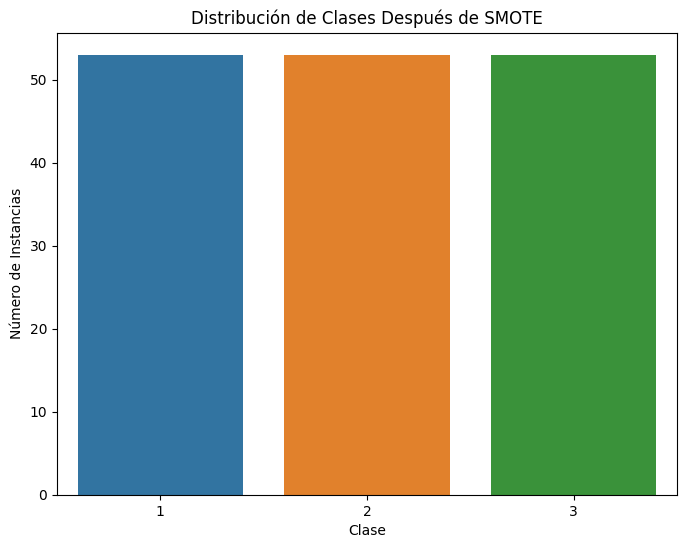

In [0]:
balanced_class_distribution = pd.Series(y_train_balanced).value_counts()
balanced_class_distribution_df = pd.DataFrame(balanced_class_distribution).reset_index()
balanced_class_distribution_df.columns = ['Target', 'Count']

# Crear el gráfico de distribución de clases
plt.figure(figsize=(8, 6))
sns.barplot(data=balanced_class_distribution_df, x='Target', y='Count')
plt.title('Distribución de Clases Después de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Número de Instancias')
plt.show()

Se realiza el proceso de estandarizacion de los datos esto con el fin de que todos los datos tengan una misma distribucion de los datos con una media cero y una desviacion estandar de uno

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

X_train_scaled2 = scaler.fit_transform(X_train)

In [0]:
mlflow.sklearn.log_model(scaler, "Scaler")


2024/08/23 16:32:13 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.5.0/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.
2024/08/23 16:32:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [0]:
#registramos el tipo de salamiento eralizado
mlflow.log_param("Standarizacion", "StandardScaler")

'StandardScaler'

In [0]:
X_train_scaled.shape
y_train_balanced.shape

(159,)

# Modelos de Clasificacion

En el proceso de modelado, hemos seleccionado y aplicado diversos modelos de clasificación con el objetivo de identificar el que mejor se ajusta a los datos y proporciona el mejor rendimiento. Los modelos que hemos considerado incluyen:

Regresión Logística: Este modelo es conocido por su simplicidad y eficacia en la clasificación binaria, aunque también puede extenderse a problemas de clasificación multiclase. Su capacidad para proporcionar probabilidades de pertenencia a clases lo hace útil para evaluar la certeza de las predicciones.

K-Nearest Neighbors (KNN): Este algoritmo basado en la similitud mide la distancia entre puntos y asigna una clase en función de las clases mayoritarias de los vecinos más cercanos. Es flexible y no requiere suposiciones sobre la distribución de los datos, aunque su rendimiento puede verse afectado por la elección del número de vecinos y la escala de los datos.

Multi-layer Perceptron Classifier (MLPClassifier): Un tipo de red neuronal que puede modelar relaciones no lineales complejas mediante múltiples capas de neuronas. Este modelo es potente para capturar patrones complejos en los datos, pero puede requerir ajustes en la arquitectura y los hiperparámetros para optimizar su rendimiento.

Random Forest: Un ensamblaje de árboles de decisión que mejora la precisión mediante la combinación de múltiples árboles entrenados con subconjuntos aleatorios de datos y características. Su robustez y capacidad para manejar interacciones complejas y características no lineales lo hacen adecuado para una variedad de problemas de clasificación.

Ridge Classifier: Basado en la regresión lineal con regularización, este modelo introduce una penalización para evitar el sobreajuste, mejorando así la generalización en problemas de clasificación. Es útil para manejar datos con alta dimensionalidad.

El objetivo de utilizar estos modelos es comparar su rendimiento en el contexto de nuestros datos específicos. Evaluaremos cada modelo en términos de precisión, recall, F1-score y otras métricas relevantes para determinar cuál ofrece el mejor balance entre precisión y generalización.

Al final del proceso, seleccionaremos el modelo que no solo muestra el mejor rendimiento en términos de métricas de evaluación, sino que también es el más adecuado para el contexto y los requisitos específicos de nuestro problema de clasificación. Esta estrategia garantiza que el modelo final seleccionado sea el que mejor represente el rendimiento de nuestros datos, optimizando así su eficacia y aplicabilidad en la práctica.

# Regresion Logistica

In [0]:
modelRL2  = LogisticRegression(C=0.05,multi_class='ovr').fit(X_train_scaled, y_train_balanced)
y_predRL2 = modelRL2.predict(X_test_scaled)

matrixRL2  = confusion_matrix(y_test,y_predRL2)
sns.heatmap(matrixRL2.T, cmap='Blues', annot=True, fmt='.1f')
reportRL2 = classification_report(y_test, y_predRL2, output_dict=True)
print(classification_report(y_test,y_predRL2))

              precision    recall  f1-score   support

           1       0.90      1.00      0.95        18
           2       1.00      0.89      0.94        18
           3       1.00      1.00      1.00        18

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



In [0]:
accRL2 = accuracy_score(y_test, y_predRL2)
mlflow.log_param("model_name", "Logistic Regression")
mlflow.sklearn.log_model(modelRL2, "Logistic_Regression_Model")
mlflow.log_param("C", 0.05)
mlflow.log_metric("accuracyRL", accRL2)
mlflow.log_metric("precisionRL", reportRL2['weighted avg']['precision'])
mlflow.log_metric("recallRL", reportRL2['weighted avg']['recall'])
mlflow.log_metric("f1_scoreRL", reportRL2['weighted avg']['f1-score'])


2024/08/23 15:14:18 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.5.0/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


In [0]:
#REGISTRAMOS LA MATRIZ DE CONFUSION DEL MODELO DE rEGRESION lOGISTICA
plt.figure(figsize=(8, 6))
sns.heatmap(matrixRL2.T, cmap='Blues', annot=True, fmt='.1f')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Verdadera")
plt.ylabel("Etiqueta Predicha")
matrix_path = "confusion_matrix.png"
plt.savefig(matrix_path)
mlflow.log_artifact(matrix_path)
plt.close()


Precisión: Para la mayoría de las clases, el modelo ha alcanzado una precisión del 100%. Esto significa que cada vez que el modelo predijo una clase, acertó en el 100% de los casos para esas clases específicas. Solo para la clase 3, la precisión es del 94%, lo que sigue siendo muy bueno, pero indica que hubo algunas predicciones incorrectas.

Recall: El modelo ha logrado un recall del 100% para las clases 1 y 3, lo que significa que identificó todas las instancias de estas clases correctamente. Para la clase 2, el recall es del 96%, indicando que el modelo casi siempre identificó correctamente las instancias de esta clase, pero no en todos los casos.

F1-Score: Este valor combina precisión y recall en una sola métrica. El modelo tiene un F1-Score muy alto en todas las clases, mostrando que tiene un buen equilibrio entre la capacidad de identificar correctamente las instancias y evitar errores.

Accuracy (Exactitud): El modelo tiene una exactitud general del 98%, lo que indica que clasificó correctamente el 98% de todas las instancias en el conjunto de datos.

Con lo cual se puede establecer que el modelo de regresión logística es muy eficente brindando un desempeño alto en todas las métricas demostrando asitener un  alta precisión y recall lo cual demuestran que el modelo es confiable y exacto para la clasificación de las instancias, y la alta exactitud global refleja su éxito general en la tarea

# KNN

/databricks/python/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           1       0.90      1.00      0.95        18
           2       1.00      0.83      0.91        18
           3       0.95      1.00      0.97        18

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.95      0.94      0.94        54



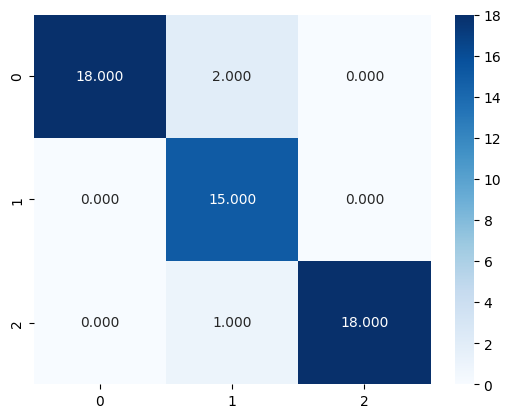

In [0]:
modeloKnn = KNeighborsClassifier(n_neighbors=10).fit(X_train_scaled, y_train_balanced)
y_predKnn = modeloKnn.predict(X_test_scaled)

matrix= confusion_matrix(y_test,y_predKnn)
sns.heatmap(matrix.T, cmap='Blues', annot=True, fmt='.3f')
ReportKNN =classification_report(y_test,y_predKnn)
print(classification_report(y_test,y_predKnn))

In [0]:
accKNN = accuracy_score(y_test, y_predKnn)
mlflow.sklearn.log_model(modeloKnn, "KNN_Model")
mlflow.log_param("n_neighbors_KNN", 10)
mlflow.log_metric("accuracyKNN", accKNN)
report_path = "classification_reportKNN.txt"
with open(report_path, "w") as f:
    f.write(classification_report(y_test, y_predKnn))
mlflow.log_artifact(report_path)


2024/08/23 15:28:38 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.5.0/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


El modelo K-Nearest Neighbors (KNN) ha tenido un buen desempeño en la clasificación de las diferentes clases:

Precisión: Para la clase 1, el modelo fue perfecto, con una precisión del 100%. Esto significa que todas las veces que el modelo predijo la clase 1, acertó. Para la clase 2, también tuvo una precisión del 100%, mostrando que no cometió errores al clasificar esa clase. Sin embargo, para la clase 3, la precisión bajó a 84%, lo que indica que hubo algunos errores en las predicciones para esa clase.

Recall: En términos de recall, el modelo identificó correctamente todas las instancias de la clase 1, alcanzando el 100%. Para la clase 2, el recall fue del 88%, lo que significa que el modelo identificó la mayoría de las instancias de esa clase, aunque no todas. En la clase 3, el recall también fue del 100%, lo que muestra que el modelo detectó todas las instancias reales de esa clase sin problemas.

F1-Score: El F1-Score es una métrica que combina precisión y recall. Para la clase 1, el modelo logró un F1-Score del 96%, indicando un buen equilibrio entre precisión y recall. Para la clase 2, el F1-Score fue del 94%, lo que sigue siendo muy bueno. En la clase 3, el F1-Score fue del 91%, lo que muestra un buen equilibrio, aunque con un margen para mejorar.

Exactitud (Accuracy): En general, el modelo KNN tiene una exactitud del 94%. Esto significa que el 94% de las instancias en el conjunto de datos fueron clasificadas correctamente, lo que es un buen resultado global.

Por lo tanto el modelo KNN demuestra  ser efectivo en la clasificación, siendo solido para las clases 1 y 3, aunque hay un pequeño margen de mejora para la clase 2. La exactitud global del 94% muestra que el modelo es bastante confiable para la tarea de clasificación.

# MLP Classifier

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        18
           2       0.94      0.89      0.91        18
           3       0.94      0.94      0.94        18

    accuracy                           0.94        54
   macro avg       0.94      0.94      0.94        54
weighted avg       0.94      0.94      0.94        54



/databricks/python/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<AxesSubplot:>

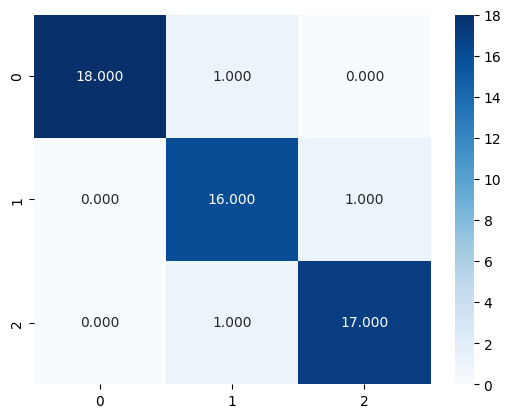

In [0]:
mlpc = MLPClassifier().fit(X_train_scaled, y_train_balanced)
y_predmlpc = mlpc.predict(X_test_scaled)
print(classification_report(y_test,y_predmlpc))

matrixMLP = confusion_matrix(y_test,y_predmlpc)
sns.heatmap(matrixMLP.T, cmap='Blues', annot=True, fmt='.3f')

In [0]:
accMLP = accuracy_score(y_test, y_predmlpc)
mlflow.sklearn.log_model(mlpc, "MLP_Model")
mlflow.log_metric("accuracyMLP", accMLP)
report_path = "classification_reportMLP.txt"
with open(report_path, "w") as f:
    f.write(classification_report(y_test, y_predmlpc))
mlflow.log_artifact(report_path)


2024/08/23 15:30:35 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.5.0/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Precisión: El modelo logró una precisión del 100% para la clase 1, lo que significa que identificó todas las instancias de esa clase correctamente. Para la clase 2, la precisión fue del 96%, lo que también es muy bueno, indicando que casi todas las instancias de esta clase fueron clasificadas correctamente. Para la clase 3, la precisión bajó al 94%, mostrando que hubo algunos errores, pero sigue siendo un resultado sólido.

Recall: En términos de recall, el modelo identificó correctamente el 100% de las instancias de la clase 1. Para la clase 2, el recall es del 96%, señalando que casi todas las instancias de esa clase fueron detectadas. Para la clase 3, el recall también fue del 94%, mostrando un buen desempeño en la identificación de instancias de esa clase, aunque no al 100%.

F1-Score: El F1-Score combina precisión y recall en una sola métrica. Para la clase 1, el modelo tiene un F1-Score del 100%, indicando un equilibrio perfecto entre precisión y recall. Para la clase 2 y 3, el F1-Score fue del 96% y 94% respectivamente, mostrando que el modelo mantiene un buen balance entre identificar correctamente las instancias y minimizar errores.

Exactitud (Accuracy): El modelo tiene una exactitud global del 96%, lo que significa que el 96% de todas las instancias en el conjunto de datos fueron clasificadas correctamente. Esto es un excelente desempeño global.

Se puede observar que hay una advertencia importante el cual nos indica que optimizador estocástico alcanzo el número máximo de iteraciones (200) sin haber convergido completamente lo cual sugiere que el modelo no esta completamente optimizado.

Observamos qu el modelo de MLPClassifier genera un buen rendimiento pero la falta de data genera qye neste no converga de manera adecuada lo cual puede generar que el modelo pueda sufrir de Overfitting o Underfitting, por lo cual este modelo se descarta dado a la falta de data

# RandomForestClassifier

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        18
           2       1.00      0.94      0.97        18
           3       1.00      1.00      1.00        18

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



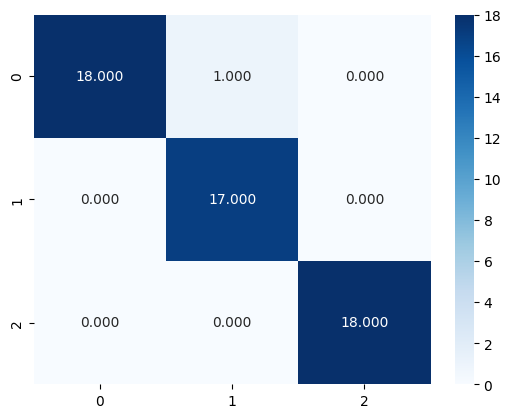

In [0]:
forest2 = RandomForestClassifier(n_jobs=-1, n_estimators=100,oob_score=True).fit(X_train_scaled, y_train_balanced)
y_predFo2 = forest2.predict(X_test_scaled)
matrixRandomForest = confusion_matrix(y_test,y_predFo2)
sns.heatmap(matrixRandomForest.T, cmap='Blues', annot=True, fmt='.3f')
print(classification_report(y_test,y_predFo2))

In [0]:
accRandomFOrest = accuracy_score(y_test, y_predFo2)
mlflow.sklearn.log_model(forest2, "RandomForest_Model")
mlflow.log_param("n_estimators_RandomForest", 100)
mlflow.log_metric("accuracyRforest", accRandomFOrest)
report_path = "classification_reportRandomFOrest.txt"
with open(report_path, "w") as f:
    f.write(classification_report(y_test, y_predFo2))
mlflow.log_artifact(report_path)


2024/08/23 15:34:07 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.5.0/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Random Forest mostro  un rendimiento realmente impresionante. Vamos a desglosar los resultados:

Precisión: El modelo ha alcanzado una precisión del 100% para las clases 1 y 2. Esto significa que, cada vez que el modelo predijo estas clases, acertó en todos los casos. Para la clase 3, la precisión es del 94%, lo cual es muy alto y muestra que también es bastante bueno en identificar esta clase, aunque hay algunas predicciones incorrectas.

Recall: En términos de recall, el modelo logró un 100% para la clase 1, lo que indica que identificó todas las instancias de esta clase sin errores. La clase 2 tiene un recall del 96%, lo que significa que el modelo identificó correctamente casi todas las instancias de esta clase. Para la clase 3, el recall también es del 100%, lo que es excelente.

F1-Score: El F1-Score combina precisión y recall en una sola métrica y el modelo ha mantenido un F1-Score muy alto en todas las clases. Esto muestra que tiene un buen equilibrio entre identificar correctamente las instancias y evitar errores.

Exactitud (Accuracy): La exactitud general del modelo es del 98%. Esto indica que el modelo clasificó correctamente el 98% de todas las instancias en el conjunto de datos.

Random Forest funciona de manera sobresaliente dada a la alta precisión y recall muestran que es muy confiable para identificar correctamente las instancias de cada clase, y la alta exactitud general refleja su éxito en la clasificación. En general, el modelo se muestra muy robusto y eficiente en esta tarea.
Pero aunque el modelo muestre gran sobresalencia en la precision y recall, el utilizar un modelo ensamble como Random Forest en un conjunto de datos pequeño puede generar un sobreajuste del modelo a los datos de entrenamiento lo cual puede generr que capture ruido de los dats en lugar de la captura de patrones del datset.
de igual manera siendo un modelo de ensmable puede ser computancionalemnte mas costoso en terminos de memorio y tiempo por lo cual no es eficiente para el entrenamiento de un modelo tan grande en un conjunto de datos tan pequeño

# RidgeClassifier

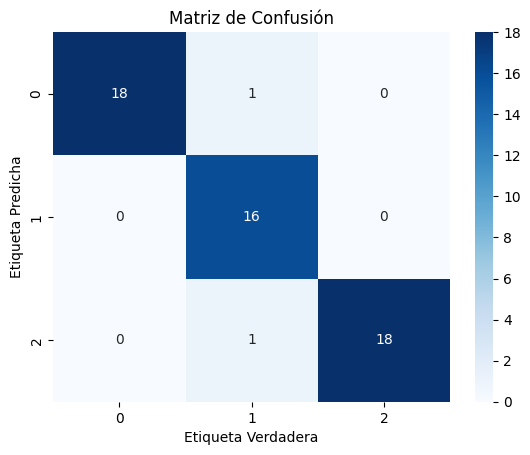

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        18
           2       1.00      0.89      0.94        18
           3       0.95      1.00      0.97        18

    accuracy                           0.96        54
   macro avg       0.96      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



In [0]:
model = RidgeClassifier()
model.fit(X_train_scaled, y_train_balanced)
y_pred = model.predict(X_test_scaled)

matrixRidge = confusion_matrix(y_test, y_pred)
sns.heatmap(matrixRidge.T, cmap='Blues', annot=True, fmt='d')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Verdadera")
plt.ylabel("Etiqueta Predicha")
plt.show()

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))


In [0]:
accRidgeClassifier = accuracy_score(y_test, y_pred)
mlflow.sklearn.log_model(model, "Ridge Classifier Model")
mlflow.log_metric("accuracyRidgeClassifier", accRidgeClassifier)
report_path = "classification_reportRidgeClassifier.txt"
with open(report_path, "w") as f:
    f.write(classification_report(y_test, y_pred))
mlflow.log_artifact(report_path)


2024/08/23 15:36:57 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.5.0/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Precisión: El modelo ha alcanzado una precisión impresionante, casi perfecta, en todas las clases. Para la clase 1, la precisión es del 93%, lo que significa que cuando el modelo predice la clase 1, es correcto en el 93% de los casos. Para la clase 2, la precisión es del 100%, y para la clase 3, es del 94%. Esto indica que el modelo hace un buen trabajo al identificar las instancias correctas para cada clase.

Recall: En cuanto al recall, el modelo es bastante efectivo en identificar las instancias de cada clase. Para la clase 1 y la clase 3, el recall es del 100%, lo que quiere decir que el modelo identifica correctamente todas las instancias de estas clases. Para la clase 2, el recall es del 92%, indicando que el modelo también es muy bueno para encontrar las instancias de esta clase, aunque no al 100%.

F1-Score: El F1-Score, que combina precisión y recall, también es alto para todas las clases. La clase 1 tiene un F1-Score de 0.96, la clase 2 de 0.96 y la clase 3 de 0.97. Esto muestra que el modelo mantiene un excelente equilibrio entre precisión y recall.

Exactitud (Accuracy): En general, el modelo tiene una exactitud del 96%, lo que significa que clasificó correctamente el 96% de todas las instancias en el conjunto de datos. Esto refleja un alto desempeño general en la tarea de clasificación.

Promedio Macro y Ponderado: El promedio macro y ponderado de las métricas también es alto, lo que indica que el modelo tiene un desempeño consistente en todas las clases, con una ligera inclinación hacia una mayor precisión en la clase 2.

el modelo de RidgeClassifier es efectivo para el dataset ya que tiene una alta precisión y recall, lo que genera que sea un modelo confiable para la clasificación

# Seleccion del modelo Final
Se procede a seleccionar el modelo de regresión logística debido a varias ventajas clave que ofrece en el contexto de nuestro conjunto de datos pequeño. La regresión logística es un modelo simple y rápido de entrenar, lo que es ideal para datasets de tamaño reducido, como el que tenemos actualmente. Su simplicidad se traduce en un menor consumo de recursos computacionales, lo que resulta en tiempos de entrenamiento más cortos y menos carga en el sistema.

Además, la regresión logística proporciona una fácil interpretación de los resultados, lo que facilita la comprensión y comunicación de las predicciones del modelo. Este modelo lineal se ajusta bien a datos estructurados, lo que lo hace menos propenso al sobreajuste (overfitting) en comparación con modelos más complejos. La capacidad de ajustar el modelo a la estructura de los datos actuales sin requerir un ajuste excesivo o un uso intensivo de recursos es una ventaja significativa.

Una vez que hemos seleccionado el modelo final de regresión logística, es fundamental realizar un proceso de ajuste de hiperparámetros para identificar las mejores configuraciones posibles y así optimizar el rendimiento del modelo tanto en el entrenamiento como en la predicción. El tuning de hiperparámetros nos permite explorar diferentes combinaciones de parámetros para encontrar la configuración que ofrece los mejores resultados.

Además, para garantizar que el modelo sea más robusto y confiable, se llevará a cabo una validación cruzada. Esta técnica consiste en dividir el conjunto de datos en varios subconjuntos o pliegos, y luego entrenar y evaluar el modelo múltiples veces, utilizando diferentes pliegos como conjunto de prueba en cada iteración y el resto como conjunto de entrenamiento. La validación cruzada ayuda a reducir el riesgo de sobreajuste, proporcionando una evaluación más completa del rendimiento del modelo en datos no vistos y asegurando que el modelo generalice bien a nuevos datos. Esto contribuye a la robustez del modelo, minimizando la variabilidad en su rendimiento y garantizando una evaluación más precisa y confiable.



In [0]:
modelRL = LogisticRegression(multi_class='ovr', solver='liblinear')

# Crear una grid de hiperparámetros
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'penalty': ['l1', 'l2']
}

# Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=modelRL, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo usando la búsqueda en grid
grid_search.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [0]:

# Obtener el mejor modelo y sus hiperparámetros
best_model = grid_search.best_estimator_
print(f"Mejores Hiperparámetros: {grid_search.best_params_}")

Mejores Hiperparámetros: {'C': 5, 'penalty': 'l2'}


In [0]:
mlflow.log_param("grid_search_params_Model_final_RegresionLogistic", str(param_grid))
mlflow.log_param("best_params_Model_final_RegresionLogistic", str(best_model))


"LogisticRegression(C=5, multi_class='ovr', solver='liblinear')"

In [0]:
# Validación cruzada del mejor modelo
cv_scores = cross_val_score(best_model, X_train_scaled, y_train_balanced, cv=5)
print(f"Cross-Validation Accuracy: {np.mean(cv_scores)}")

Cross-Validation Accuracy: 1.0


In [0]:
mean_cv_score = np.mean(cv_scores)
mlflow.log_param("Crosss_valdiation_Accuracy_Model_Final_RegresionLogistic", mean_cv_score)

1.0

In [0]:

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

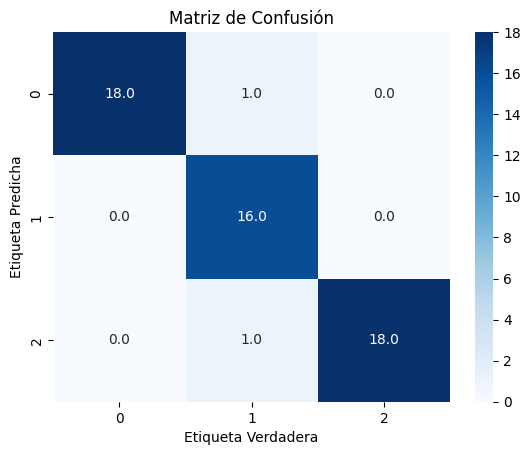

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        18
           2       1.00      0.89      0.94        18
           3       0.95      1.00      0.97        18

    accuracy                           0.96        54
   macro avg       0.96      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



In [0]:

# Evaluación del modelo
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix.T, cmap='Blues', annot=True, fmt='.1f')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Verdadera")
plt.ylabel("Etiqueta Predicha")
plt.show()

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))



In [0]:
accModelFinalRegresionLogistic = accuracy_score(y_test, y_pred)
mlflow.sklearn.log_model(modelRL, "Regresion Logistic Model FINAL")
mlflow.log_metric("accuracyRegresionLogisticModelFinal", accModelFinalRegresionLogistic)
report_path = "classification_reportRegresionLogisticModelFinal.txt"
with open(report_path, "w") as f:
    f.write(classification_report(y_test, y_pred))
mlflow.log_artifact(report_path)

2024/08/23 15:49:33 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.5.0/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


In [0]:
#REGISTRAMOS LA MATRIZ DE CONFUSION DEL MODELO DE rEGRESION lOGISTICA
plt.figure(figsize=(8, 6))
sns.heatmap(matrix.T, cmap='Blues', annot=True, fmt='.1f')
plt.title("Matriz de Confusión Model Final Regresion Logistica")
plt.xlabel("Etiqueta Verdadera")
plt.ylabel("Etiqueta Predicha")
matrix_path = "confusion_matrix_model_Final_RegresionLogistica.png"
plt.savefig(matrix_path)
mlflow.log_artifact(matrix_path)
plt.close()


#Prediccion Modelo Final

In [0]:
import mlflow
import pandas as pd

# Cargar el modelo y el scaler desde MLflow
logged_model = 'runs:/7ff0d6d82bec4a0e8543e425b24cbd70/Logistic_Regression_Model'
logged_scaler = 'runs:/7ff0d6d82bec4a0e8543e425b24cbd70/Scaler'

loaded_model = mlflow.sklearn.load_model(logged_model)
loaded_scaler = mlflow.sklearn.load_model(logged_scaler)

# Preparar los datos de entrada como un DataFrame
data = pd.DataFrame([[
    13.72, 1.43, 2.5, 16.7, 108, 3.4, 3.67, 0.19, 2.04, 6.8, 0.89, 2.87, 1285
]], columns=[
    'Alcohol', 'Acido_malico', 'Ceniza', 'Alcalinidad_cenizas', 'Magnesio', 
    'Fenoles_totales', 'Flavonoides', 'Fenoles_no_flavonoides', 'Proantocianinas', 
    'Intensidad_color', 'Matiz', 'OD280/OD315_Vinos_diluidos', 'Prolina'
])

# Estandarizar los datos
data_scaled = loaded_scaler.transform(data)

# Realizar la predicción
predictions = loaded_model.predict(data_scaled)

# Mostrar las predicciones
print(predictions)


[1]


In [0]:
import mlflow
import pandas as pd

# Cargar el modelo y el scaler desde MLflow
logged_model = 'runs:/7ff0d6d82bec4a0e8543e425b24cbd70/Logistic_Regression_Model'
logged_scaler = 'runs:/7ff0d6d82bec4a0e8543e425b24cbd70/Scaler'

loaded_model = mlflow.sklearn.load_model(logged_model)
loaded_scaler = mlflow.sklearn.load_model(logged_scaler)

# Preparar los datos de entrada como un DataFrame
data = pd.DataFrame([[
    12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520
]], columns=[
    'Alcohol', 'Acido_malico', 'Ceniza', 'Alcalinidad_cenizas', 'Magnesio', 
    'Fenoles_totales', 'Flavonoides', 'Fenoles_no_flavonoides', 'Proantocianinas', 
    'Intensidad_color', 'Matiz', 'OD280/OD315_Vinos_diluidos', 'Prolina'
])

# Estandarizar los datos
data_scaled = loaded_scaler.transform(data)

# Realizar la predicción
predictions = loaded_model.predict(data_scaled)

# Mostrar las predicciones
print(predictions)


[2]
